# Predicting food supply

In [99]:
from joblib import dump
from scipy.stats import boxcox
from xgboost import XGBRegressor
from plotly.subplots import make_subplots

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [100]:
url = "https://raw.githubusercontent.com/daBawse167/owid-datasets/master/datasets/Food%20supply%20(FAO%2C%202020)/Food%20supply%20(FAO%2C%202020).csv"
df = pd.read_csv(url)
df

,Entity,Year,Food supply (kcal/capita/day) - Grand Total,Fat supply quantity (g/capita/day) - Grand Total,Protein supply quantity (g/capita/day) - Grand Total,Meat food supply quantity (kg/capita/yr),Bovine meat food supply quantity (kg/capita/yr),Poultry meat food supply quantity (kg/capita/yr),Pigmeat food supply quantity (kg/capita/yr),Mutton & Goat meat food supply quantity (kg/capita/yr),"Meat, Other, Food supply quantity (kg/capita/yr)",Eggs - Food supply quantity (kg/capita/yr),Milk - Excluding Butter - Food supply quantity (kg/capita/yr),"Fish, Seafood- Food supply quantity (kg/capita/yr)",Animal Products - Protein supply quantity (g/capita/day),Vegetal Products - Protein supply quantity (g/capita/day),Fruits - Excluding Wine - Food supply quantity (kg/capita/yr),Vegetables - Food supply quantity (kg/capita/yr)
0,Afghanistan,1961,2999,37.51,84.91,14.45,4.80,0.63,NaN,8.18,0.85,0.94,59.30,0.03,13.53,71.38,41.13,36.75
1,Afghanistan,1962,2917,37.61,82.98,14.46,5.01,0.66,NaN,7.92,0.88,1.01,58.57,0.03,13.48,69.50,38.00,37.47
2,Afghanistan,1963,2698,38.57,77.12,14.88,5.06,0.66,NaN,8.09,1.07,1.04,63.87,0.03,14.20,62.92,38.25,38.87
3,Afghanistan,1964,2953,38.95,83.49,15.07,5.03,0.67,NaN,8.35,1.01,1.06,64.05,0.03,14.33,69.16,47.92,40.17
4,Afghanistan,1965,2956,39.73,83.86,15.38,4.99,0.70,NaN,8.64,1.06,1.10,68.62,0.03,14.94,68.92,48.69,40.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11023,Zimbabwe,2013,2110,57.18,48.35,18.24,7.37,4.97,2.65,0.96,2.29,1.75,31.90,2.82,11.76,36.59,15.32,16.04
11024,Zimbabwe,2014,2199,57.13,51.41,17.91,7.26,4.49,1.84,1.74,2.58,1.93,30.54,3.39,11.66,39.75,15.41,16.28
11025,Zimbabwe,2015,2172,56.58,50.29,17.81,7.25,4.67,1.74,1.58,2.56,1.84,27.38,3.82,11.46,38.82,15.44,16.02
11026,Zimbabwe,2016,2176,57.25,50.78,18.01,7.23,4.70,1.77,1.69,2.62,1.86,28.20,3.79,11.64,39.14,12.80,15.95


In [101]:
np.unique(df['Entity'])

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Americas',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Asia',
       'Asia, Central', 'Australia', 'Australia & New Zealand', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Caribbean', 'Central African Republic',
       'Central America', 'Chad', 'Chile', 'China', 'Colombia', 'Congo',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Czechoslovakia', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Eastern Africa', 'Eastern Asia',
       'Eastern Europe', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Ethiopia', 'Ethiopia PDR', 'Europe', 'Europe, Western',
       'European Union', 

## Correlations

### Heatmap

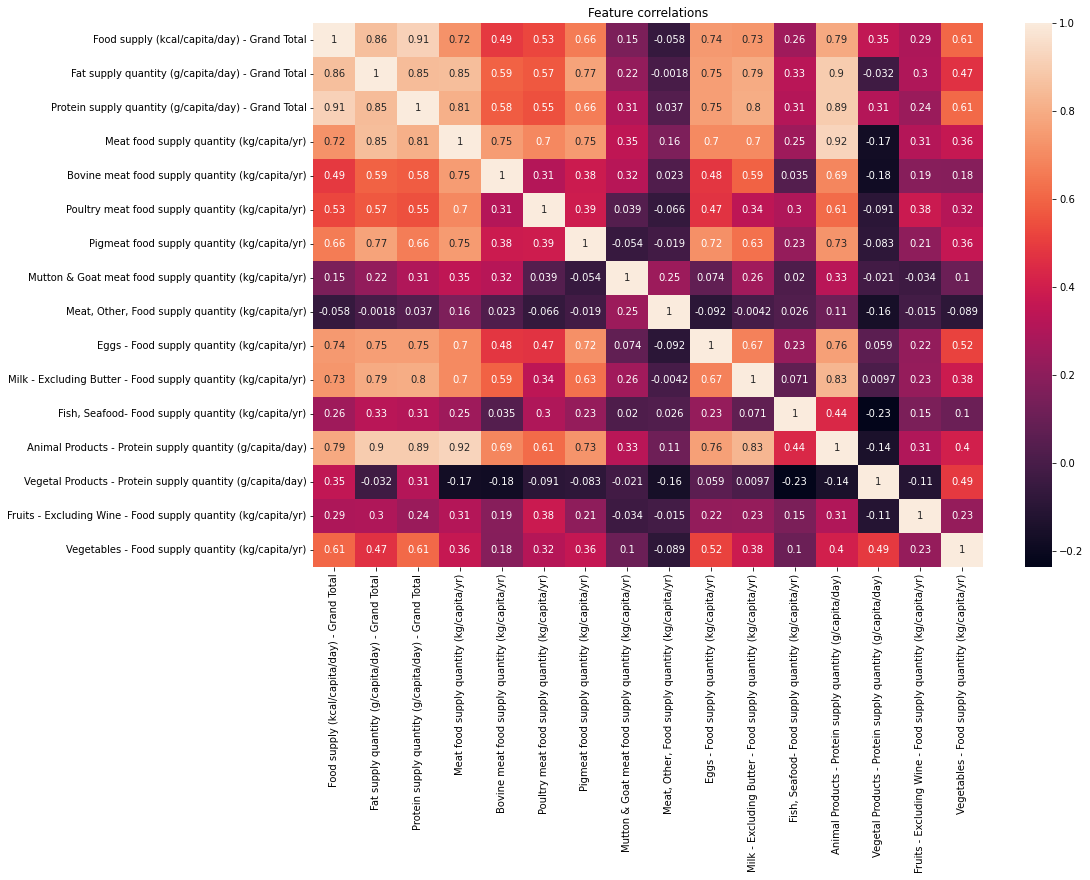

In [102]:
correlations = df.drop(['Entity', 'Year'], axis=1).corr()
most_correlating = correlations['Food supply (kcal/capita/day) - Grand Total'].sort_values(ascending=False)[1:]

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(correlations, annot=True)
plt.title("Feature correlations")
plt.show()

In [103]:
print(most_correlating)
most_correlating = most_correlating[:6]

Protein supply quantity (g/capita/day) - Grand Total             0.914816
Fat supply quantity (g/capita/day) - Grand Total                 0.858554
Animal Products - Protein supply quantity (g/capita/day)         0.788569
Eggs - Food supply quantity (kg/capita/yr)                       0.740678
Milk - Excluding Butter - Food supply quantity (kg/capita/yr)    0.730951
Meat food supply quantity (kg/capita/yr)                         0.721624
Pigmeat food supply quantity (kg/capita/yr)                      0.661921
Vegetables - Food supply quantity (kg/capita/yr)                 0.606582
Poultry meat food supply quantity (kg/capita/yr)                 0.525328
Bovine meat food supply quantity (kg/capita/yr)                  0.491702
Vegetal Products - Protein supply quantity (g/capita/day)        0.350575
Fruits - Excluding Wine - Food supply quantity (kg/capita/yr)    0.291792
Fish, Seafood- Food supply quantity (kg/capita/yr)               0.256476
Mutton & Goat meat food supply quantit

### Scatter graphs

In [104]:
corr_cols = np.append(most_correlating.index, ['Food supply (kcal/capita/day) - Grand Total'])
df_corr = df[corr_cols].iloc[::5, :]

fig = make_subplots(rows=3, cols=2, subplot_titles=corr_cols[:-1])
fig.update_layout(title_text='Correlation of food supply with other features')

i = 0
for row in range(1, 4):
    for col in range(1, 3):
        fig.add_trace(go.Scatter(x=df_corr[corr_cols[-1]], y=df_corr[corr_cols[i]], mode='markers'), row, col)
        i += 1
fig.show()

## World map

In [105]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.index = world['name']
df_world = df.copy()

df_world['Entity'] = np.where(df_world['Entity']=='United States', 'United States of America', df_world['Entity'])
df_world['Entity'] = np.where(df_world['Entity']=='Bosnia and Herzegovina', 'Bosnia and Herz.', df_world['Entity'])
df_world['Entity'] = np.where(df_world['Entity']=='Central African Republic', 'Central African Rep.', df_world['Entity'])
df_world['Entity'] = np.where(df_world['Entity']=='Czech Republic', 'Czechia', df_world['Entity'])
df_world['Entity'] = np.where(df_world['Entity']=='Dominican Republic', 'Dominican Rep.', df_world['Entity'])
df_world['Entity'] = np.where(df_world['Entity']=='Ethiopia PDR', 'Ethiopia', df_world['Entity'])

world = world.reindex(df_world['Entity']).reset_index()
world['iso_a3'] = world['iso_a3'].fillna("NaN")
df_world['iso_a3'] = world['iso_a3']

fig = px.choropleth(df_world, locations="iso_a3", color='Food supply (kcal/capita/day) - Grand Total', animation_frame='Year')
fig.show()

## Countries' food supply over the years

In [106]:
countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'China', 'Russia']

fig = make_subplots(rows=3, cols=2, subplot_titles=countries)
fig.update_layout(title_text='Food supply over the years')

i = 0
for row in range(1, 4):
    for col in range(1, 3):
        country = countries[i]
        data = df[df['Entity']==country][['Year', 'Food supply (kcal/capita/day) - Grand Total']]
        fig.add_trace(go.Scatter(x=data['Year'], y=data['Food supply (kcal/capita/day) - Grand Total']), row, col)
        i += 1
fig.show()

## Removing null values

In [107]:
df.isnull().sum()

Entity                                                             0
Year                                                               0
Food supply (kcal/capita/day) - Grand Total                        0
Fat supply quantity (g/capita/day) - Grand Total                   0
Protein supply quantity (g/capita/day) - Grand Total               0
Meat food supply quantity (kg/capita/yr)                           0
Bovine meat food supply quantity (kg/capita/yr)                    0
Poultry meat food supply quantity (kg/capita/yr)                   0
Pigmeat food supply quantity (kg/capita/yr)                      276
Mutton & Goat meat food supply quantity (kg/capita/yr)             0
Meat, Other, Food supply quantity (kg/capita/yr)                   0
Eggs - Food supply quantity (kg/capita/yr)                         0
Milk - Excluding Butter - Food supply quantity (kg/capita/yr)      0
Fish, Seafood- Food supply quantity (kg/capita/yr)                 0
Animal Products - Protein supply q

In [108]:
avg = np.nanmean(df['Pigmeat food supply quantity (kg/capita/yr)'])
df = df.fillna(avg)

In [109]:
df

,Entity,Year,Food supply (kcal/capita/day) - Grand Total,Fat supply quantity (g/capita/day) - Grand Total,Protein supply quantity (g/capita/day) - Grand Total,Meat food supply quantity (kg/capita/yr),Bovine meat food supply quantity (kg/capita/yr),Poultry meat food supply quantity (kg/capita/yr),Pigmeat food supply quantity (kg/capita/yr),Mutton & Goat meat food supply quantity (kg/capita/yr),"Meat, Other, Food supply quantity (kg/capita/yr)",Eggs - Food supply quantity (kg/capita/yr),Milk - Excluding Butter - Food supply quantity (kg/capita/yr),"Fish, Seafood- Food supply quantity (kg/capita/yr)",Animal Products - Protein supply quantity (g/capita/day),Vegetal Products - Protein supply quantity (g/capita/day),Fruits - Excluding Wine - Food supply quantity (kg/capita/yr),Vegetables - Food supply quantity (kg/capita/yr)
0,Afghanistan,1961,2999,37.51,84.91,14.45,4.80,0.63,11.716982,8.18,0.85,0.94,59.30,0.03,13.53,71.38,41.13,36.75
1,Afghanistan,1962,2917,37.61,82.98,14.46,5.01,0.66,11.716982,7.92,0.88,1.01,58.57,0.03,13.48,69.50,38.00,37.47
2,Afghanistan,1963,2698,38.57,77.12,14.88,5.06,0.66,11.716982,8.09,1.07,1.04,63.87,0.03,14.20,62.92,38.25,38.87
3,Afghanistan,1964,2953,38.95,83.49,15.07,5.03,0.67,11.716982,8.35,1.01,1.06,64.05,0.03,14.33,69.16,47.92,40.17
4,Afghanistan,1965,2956,39.73,83.86,15.38,4.99,0.70,11.716982,8.64,1.06,1.10,68.62,0.03,14.94,68.92,48.69,40.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11023,Zimbabwe,2013,2110,57.18,48.35,18.24,7.37,4.97,2.650000,0.96,2.29,1.75,31.90,2.82,11.76,36.59,15.32,16.04
11024,Zimbabwe,2014,2199,57.13,51.41,17.91,7.26,4.49,1.840000,1.74,2.58,1.93,30.54,3.39,11.66,39.75,15.41,16.28
11025,Zimbabwe,2015,2172,56.58,50.29,17.81,7.25,4.67,1.740000,1.58,2.56,1.84,27.38,3.82,11.46,38.82,15.44,16.02
11026,Zimbabwe,2016,2176,57.25,50.78,18.01,7.23,4.70,1.770000,1.69,2.62,1.86,28.20,3.79,11.64,39.14,12.80,15.95


In [110]:
X = df.drop(['Food supply (kcal/capita/day) - Grand Total', "Entity"], axis=1)
y = df['Food supply (kcal/capita/day) - Grand Total']

features = ['Protein supply quantity (g/capita/day) - Grand Total',
'Fat supply quantity (g/capita/day) - Grand Total',
'Animal Products - Protein supply quantity (g/capita/day)',
'Eggs - Food supply quantity (kg/capita/yr)',
'Milk - Excluding Butter - Food supply quantity (kg/capita/yr)',
'Meat food supply quantity (kg/capita/yr)',
'Pigmeat food supply quantity (kg/capita/yr)',
'Vegetables - Food supply quantity (kg/capita/yr)']

X = X[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [111]:
correlations['Food supply (kcal/capita/day) - Grand Total'].sort_values(ascending=False)[1:][:8]

Protein supply quantity (g/capita/day) - Grand Total             0.914816
Fat supply quantity (g/capita/day) - Grand Total                 0.858554
Animal Products - Protein supply quantity (g/capita/day)         0.788569
Eggs - Food supply quantity (kg/capita/yr)                       0.740678
Milk - Excluding Butter - Food supply quantity (kg/capita/yr)    0.730951
Meat food supply quantity (kg/capita/yr)                         0.721624
Pigmeat food supply quantity (kg/capita/yr)                      0.661921
Vegetables - Food supply quantity (kg/capita/yr)                 0.606582
Name: Food supply (kcal/capita/day) - Grand Total, dtype: float64

## Evalutating predictors

In [112]:
for model in [SVR(), SGDRegressor(), RandomForestRegressor(), XGBRegressor()]:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(model)
    print(model.score(X_test, y_test))
    print(mae(y_test, y_pred))
    print(mse(y_test, y_pred))
    print("")

SVR()
0.7566331186270294
200.93009920984213
64654.56756335097

SGDRegressor()
-3.990955731008673e+20
8802235894296.023
1.0602655361203199e+26

RandomForestRegressor()
0.973721335461617
57.54796464188576
6981.375946826836

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
0.9735598264542822
60.85111107225323
7024.283572416263



In [113]:
model = XGBRegressor(n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_test, y_test))
print(mae(y_test, y_pred))
print(mse(y_test, y_pred))

predictions = pd.DataFrame({'prediction':y_pred, 'real':y_test})
predictions

0.9761107304325791
57.561627081060884
6346.59237350716


,prediction,real
7852,2139.732910,2166
11007,2006.787109,2009
5109,2649.959229,2671
3589,2632.656494,2653
9845,2000.244019,2076
...,...,...
1503,2366.855957,2344
10425,2704.467041,2739
1266,2046.662598,1987
6984,2878.951416,2975


In [139]:
dump(model, "model.joblib")

['model.joblib']

In [115]:
"""scores = []
for i in range(16):
    features = i+1
    feature_scores = []
    for i in range(10):
        pca = PCA(n_components=features).fit(X, y)
        data = pca.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
        model = XGBRegressor(n_estimators=200).fit(X_train, y_train)
        score = model.score(X_test, y_test)
        feature_scores.append(score)
    avg_score = np.mean(feature_scores)
    scores.append(avg_score)

plt.plot(range(len(scores)), scores)"""

'scores = []\nfor i in range(16):\n    features = i+1\n    feature_scores = []\n    for i in range(10):\n        pca = PCA(n_components=features).fit(X, y)\n        data = pca.transform(X)\n        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)\n        model = XGBRegressor(n_estimators=200).fit(X_train, y_train)\n        score = model.score(X_test, y_test)\n        feature_scores.append(score)\n    avg_score = np.mean(feature_scores)\n    scores.append(avg_score)\n\nplt.plot(range(len(scores)), scores)'